In [1]:
import os
from os.path import join

import numpy as np

import plotly.graph_objects as go

import sys
plantbox_path = os.environ["PLANTBOX_PATH"]
sys.path.append(plantbox_path)

import plantbox as pb
from plantbox import RootSystem, SegmentAnalyser

In [218]:
os.listdir(param_dir)

['Anagallis_femina_Leitner_2010.xml',
 'Medicago_truncatula_Postma_2011.xml',
 'Maize.vtk',
 'Heliantus_Pagès_2013.xml',
 'Noccaea_Pagès_2013.xml',
 'maize_p3_zero_std.xml',
 'Crypsis_aculeata_Clausnitzer_1994.xml',
 'Juncus_squarrosus_Clausnitzer_1994.xml',
 'Zea_mays_2_Pagès_2014.xml',
 'Zea_mays_3_Postma_2011.xml',
 'maize_p2_zero_std.xml',
 'maize.xml',
 'Zea_mays_4_Leitner_2014.xml',
 'Zea_mays_6_Leitner_2014.xml',
 'Pisum_sativum_b_TSEGAYE_1995.xml',
 'maize_p2.xml',
 'Pisum_sativum_c_TSEGAYE_1995.xml',
 'maize_p3.xml',
 'virtual.xml',
 'maize_p1.xml',
 'workshop.xml',
 'Zea_mays_1_Leitner_2010.xml',
 'Pisum_sativum_d_TSEGAYE_1995.xml',
 'Zea_mays_5_Leitner_2014.xml',
 'maize_p1_zero_std.xml',
 'wheat.xml',
 'Lupinus_albus_Leitner_2014.xml',
 'Triticum_aestivum_a_Bingham_2011.xml',
 'Brassica_napus_a_Leitner_2010.xml',
 'Pisum_sativum_a_Pagès_2014.xml',
 'Lupinus_angustifolius_Chen_2011.xml',
 'Brassica_oleracea_Vansteenkiste_2014.xml']

In [3]:
name = "Anagallis_femina_Leitner_2010"
"Brassica_napus_a_Leitner_2010"
"Brassica napus a Leitner"
param_path = join(param_dir,  f"{name}.xml")

In [20]:
rs = RootSystem()
rs.readParameters(param_path)
rs.initialize()
rs.simulate(2)

In [221]:
class Root:
    """Root.
    
    Wrapper for CPlantBox Rootsystem.
    """

    def __init__(self, root_system: RootSystem):
        self.lines = [to_array(s) for s in root_system.getPolylines()]
        self.nodes, unique_nodes_idx = np.unique(np.concatenate(self.lines),
                                                 axis=0, return_index=True)
        self.radii = np.array(root_system.getParameter("radius"))
        nodes_weights = np.repeat(self.radii, [len(line) for line in self.lines])
        self.nodes_weights = nodes_weights[unique_nodes_idx]

        # self.nodes = to_array(root_system.getNodes())
        # self.segments = to_array(root_system.getSegments()) - 1
        self.plot_rescale_factor = 5 / self.radii.max()

    @classmethod
    def from_file(cls, path: str, age: int):
        root_system = RootSystem()
        root_system.readParameters(path)
        root_system.initialize()
        root_system.simulate(age)
        return cls(root_system)

    def plot(self, draw_nodes=False):
        trace = [go.Scatter3d(x=line[:, 0],
                              y=line[:, 1],
                              z=line[:, 2],
                              mode='lines',
                              line=dict(width=self.plot_rescale_factor * radius))
                 for line, radius in zip(self.lines, self.radii)]

        if draw_nodes:
            nodes = go.Scatter3d(
                x=self.nodes[:, 0],
                y=self.nodes[:, 1],
                z=self.nodes[:, 2],
                mode='markers',
                marker=dict(
                    color="black",
                    size=1.2,
                ),
                name="plant"
            )
            trace.append(nodes)
        
        fig = go.Figure(data=trace)
        fig.update_layout(scene_aspectmode='data')

        return fig

    @property
    def n_nodes(self):
        return len(self.nodes)

    # @property
    # def n_segments(self):
    #     return len(self.segments)

    @property
    def n_lines(self):
        return len(self.lines)


def to_array(root_system_iter):
    return np.vstack([np.array(elem) for elem in root_system_iter])


In [153]:
rs.initialize()
rs.simulate(3)
pyroot = Root(rs)
pyroot.nodes_weights.shape, pyroot.nodes.shape

((152,), (152, 3))

In [151]:
# rs.initialize()
# rs.simulate(14)
# pyroot = Root(rs)
fig = pyroot.plot(draw_nodes=True)
fig

In [23]:
fig.write_image(join(os.environ["HOME"], "Images", "root.svg"))

## Optimal Transport

In [214]:
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.spatial import distance_matrix
plt.style.use("seaborn")

In [250]:
anagallis_file = "Anagallis_femina_Leitner_2010"
anagallis_path = join(param_dir,  f"{anagallis_file}.xml")

brassica_file = "Brassica_oleracea_Vansteenkiste_2014"
brassica_path = join(param_dir,  f"{brassica_file}.xml")

In [251]:
anagallis = Root.from_file(anagallis_path, age=4)
print(anagallis.n_nodes, "nodes")
anagallis_fig = anagallis.plot()
anagallis_fig

191 nodes


In [246]:
brassica = Root.from_file(brassica_path, age=6)
print(brassica.n_nodes, "nodes")
brassica_fig = brassica.plot()
brassica_fig

159 nodes


In [254]:
a = np.random.rand(7, 13)
a.sum(0).shape

(13,)

In [267]:
def discrete_ot(root_1: Root, root_2: Root):
    """Balanced discrete Optimal Transport."""
    sq_dist_matrix = distance_matrix(root_1.nodes, root_2.nodes)**2
    P = cp.Variable((root_1.n_nodes, root_2.n_nodes))
    constraints = [
        P >= 0,
        cp.sum(P, axis=1) == root_1.nodes_weights / root_1.nodes_weights.sum(),
        cp.sum(P, axis=0) == root_2.nodes_weights / root_2.nodes_weights.sum(),
    ]
    objective = cp.Minimize(cp.sum(cp.multiply(P, sq_dist_matrix)))
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return P, result

In [268]:
coupling, wasserstein_dist = discrete_ot(anagallis, brassica)
wasserstein_dist

34.66009533442224

In [272]:
anagallis_2 = Root.from_file(anagallis_path, age=6)
print(anagallis_2.n_nodes)
coupling, wasserstein_dist = discrete_ot(anagallis, anagallis_2)
wasserstein_dist

9.265631198023671

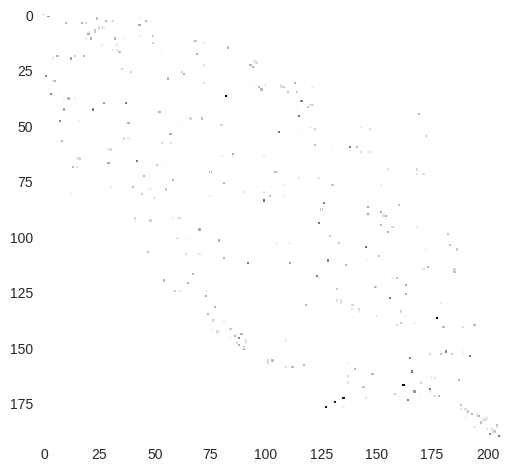

In [271]:
plt.imshow(coupling.value)